In [1]:
from pathlib import Path
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
p5 = partial(np.quantile, q=0.05)
p95 = partial(np.quantile, q=0.95)

sanyaku = [
    'yokozuna',
    'ozeki',
    'sekiwake',
    'komusubi',
]
makuuchi = sanyaku.copy() + ['maegashira']
sekitori = makuuchi.copy() + ['juryo']

idx_cols = ['rikishi_id', 'basho_id']

In [3]:
data_path = Path('data/processed/json/')

In [13]:
weights = pd.read_json(data_path.joinpath('weights.json')).set_index('basho_id')
heights = pd.read_json(data_path.joinpath('heights.json')).set_index('basho_id')
bashos = pd.read_json(data_path.joinpath('bashos.json')).set_index('id')

In [10]:
ranks = pd.read_json(data_path.joinpath('ranks.json'))
ranks.rename(columns={'rank': 'raw_rank', 'id': 'rikishi_id'}, inplace=True)
ranks['rank'] = ranks['raw_rank'].map(lambda x: x['rank'] if x else pd.NA)
ranks['level'] = ranks['raw_rank'].map(lambda x: x['level'] if x else pd.NA)
ranks['side'] = ranks['raw_rank'].map(lambda x: x['side'] if x else pd.NA)
ranks.drop(columns='raw_rank', inplace=True)

ranks['sanyaku'] = ranks['rank'].isin(sanyaku)
ranks['makuuchi'] = ranks['rank'].isin(makuuchi)
ranks['sekitori'] = ranks['rank'].isin(sekitori)

ranks.set_index(idx_cols, inplace=True)

assert ranks.loc[ranks['rank'] == 'juryo', 'sekitori'].all() == True
assert ranks.loc[ranks['rank'] == 'maegashira', 'makuuchi'].all() == True
assert ranks['rank'].nunique() == 10


In [14]:
weights = weights.join(bashos.loc[:, 'year'], how='left')
assert weights['year'].nunique() == bashos['year'].nunique()
assert weights['year'].isna().any() == False

weights.reset_index(inplace=True)
weights.rename(columns={'index': 'basho_id'}, inplace=True)
weights.set_index(idx_cols, inplace=True)

weights = weights.join(ranks, how='left')
print(weights.shape)
weights = weights.dropna()
print(weights.shape)

assert weights['rank'].isna().any() == False

(285029, 8)
(241228, 8)


In [15]:
heights = heights.join(bashos.loc[:, 'year'], how='left')
assert heights['year'].nunique() == bashos['year'].nunique()
assert heights['year'].isna().any() == False

heights.reset_index(inplace=True)
heights.rename(columns={'index': 'basho_id'}, inplace=True)
heights.set_index(idx_cols, inplace=True)

heights = heights.join(ranks, how='left')

print(heights.shape)
heights = heights.dropna()
print(heights.shape)

assert heights['rank'].isna().any() == False

(285029, 8)
(241228, 8)


# Weight Analysis

To count for increases in height, correlated to weight, we add BMI, though not perfect as a measure, because it counts for height, it'll help to show a trend on weight increase that could be explained by height alone.

In [16]:
mask = (~weights['weight'].isna().values) & (~heights['height'].isna().values)
cols = [
    'year',
    'weight',
    'rank',
    'sanyaku',
    'makuuchi',
    'sekitori',
]

w = weights.loc[mask, cols]
w['bmi'] = w['weight'] / (heights.loc[mask, 'height'].values / 100) ** 2

In [17]:
base = w.groupby(by=['rikishi_id', 'year']).agg(
    weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()


s = base.groupby(by=['year']).agg(
    mean=pd.NamedAgg(column='weight', aggfunc='mean'),
    std=pd.NamedAgg(column='weight', aggfunc='std'),
    median=pd.NamedAgg(column='weight', aggfunc='median'),
    p5=pd.NamedAgg(column='weight', aggfunc=p5),
    p95=pd.NamedAgg(column='weight', aggfunc=p95),
    bmi_mean=pd.NamedAgg(column='bmi', aggfunc='mean'),
    bmi_std=pd.NamedAgg(column='bmi', aggfunc='std'),
    bmi_median=pd.NamedAgg(column='bmi', aggfunc='median'),
    bmi_p5=pd.NamedAgg(column='bmi', aggfunc=p5),
    bmi_p95=pd.NamedAgg(column='bmi', aggfunc=p95),
).reset_index()


This is for all wrestler's in all divisions, thus we won't see much as lower divisions tend to be lower weight than higher ones. This is because mostly lower divisions are fill by young wrestlers just starting or not very good ones.

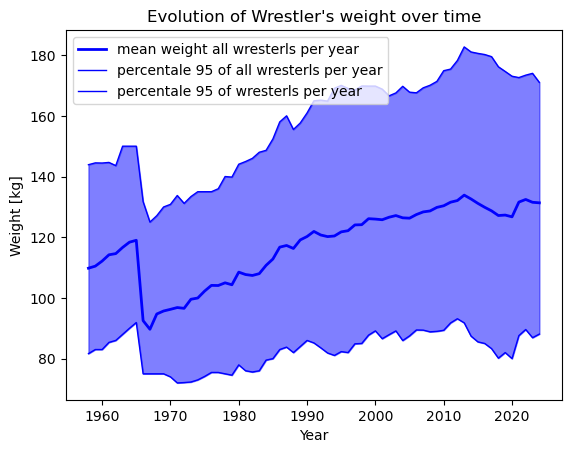

In [18]:
plt.fill_between(s['year'], y1=s['p5'], y2=s['p95'], color='blue', alpha=0.5)
plt.plot(s['year'], s['mean'], color='blue', linewidth=2, label='mean weight all wresterls per year')
plt.plot(s['year'], s['p5'], color='blue', linewidth=1, label='percentale 95 of all wresterls per year')
plt.plot(s['year'], s['p95'], color='blue', linewidth=1, label='percentale 95 of wresterls per year')
plt.title("Evolution of Wrestler's weight over time")
plt.xlabel('Year')
plt.ylabel('Weight [kg]')
plt.legend()
plt.show();

What happened thoug in the mid 60s??!!!

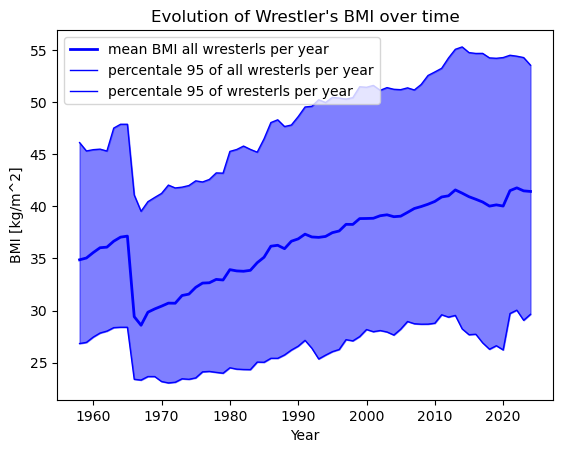

In [19]:
plt.fill_between(s['year'], y1=s['bmi_p5'], y2=s['bmi_p95'], color='blue', alpha=0.5)
plt.plot(s['year'], s['bmi_mean'], color='blue', linewidth=2, label='mean BMI all wresterls per year')
plt.plot(s['year'], s['bmi_p5'], color='blue', linewidth=1, label='percentale 95 of all wresterls per year')
plt.plot(s['year'], s['bmi_p95'], color='blue', linewidth=1, label='percentale 95 of wresterls per year')
plt.title("Evolution of Wrestler's BMI over time")
plt.xlabel('Year')
plt.ylabel('BMI [kg/m^2]')
plt.legend()
plt.show();

As expected, from above we can't see much other than weight has gone up, but in what divisions?

Here we analyse different ranks. First makuuchi, then sanyaku and finally maegashiras, and all the senyaku.

In [22]:
mask = w['makuuchi'] == True

base = w.loc[mask, :].groupby(by=['rikishi_id', 'year']).agg(
    weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()

s = base.groupby(by='year').agg(
    mean=pd.NamedAgg(column='weight', aggfunc='mean'),
    std=pd.NamedAgg(column='weight', aggfunc='std'),
    median=pd.NamedAgg(column='weight', aggfunc='median'),
    p5=pd.NamedAgg(column='weight', aggfunc=p5),
    p95=pd.NamedAgg(column='weight', aggfunc=p95),
    bmi_mean=pd.NamedAgg(column='bmi', aggfunc='mean'),
    bmi_std=pd.NamedAgg(column='bmi', aggfunc='std'),
    bmi_median=pd.NamedAgg(column='bmi', aggfunc='median'),
    bmi_p5=pd.NamedAgg(column='bmi', aggfunc=p5),
    bmi_p95=pd.NamedAgg(column='bmi', aggfunc=p95),
).reset_index()

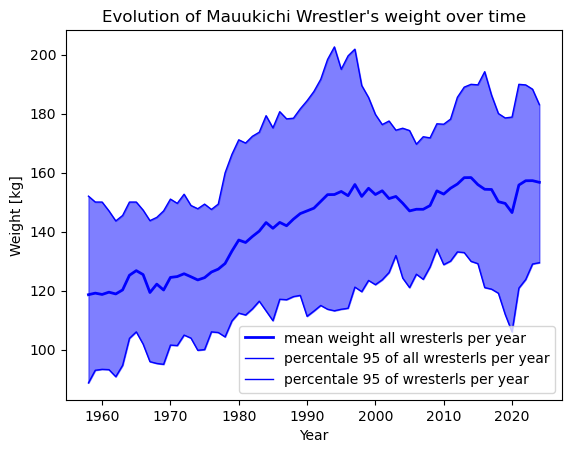

In [23]:
plt.fill_between(s['year'], y1=s['p5'], y2=s['p95'], color='blue', alpha=0.5)
plt.plot(s['year'], s['mean'], color='blue', linewidth=2, label='mean weight all wresterls per year')
plt.plot(s['year'], s['p5'], color='blue', linewidth=1, label='percentale 95 of all wresterls per year')
plt.plot(s['year'], s['p95'], color='blue', linewidth=1, label='percentale 95 of wresterls per year')
plt.title("Evolution of Mauukichi Wrestler's weight over time")
plt.xlabel('Year')
plt.ylabel('Weight [kg]')
plt.legend()
plt.show();

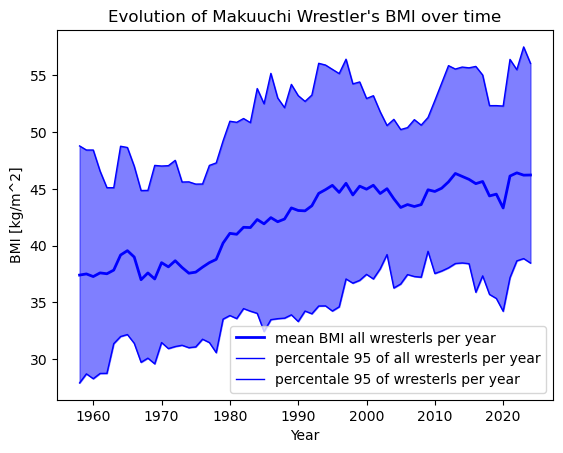

In [25]:
plt.fill_between(s['year'], y1=s['bmi_p5'], y2=s['bmi_p95'], color='blue', alpha=0.5)
plt.plot(s['year'], s['bmi_mean'], color='blue', linewidth=2, label='mean BMI all wresterls per year')
plt.plot(s['year'], s['bmi_p5'], color='blue', linewidth=1, label='percentale 95 of all wresterls per year')
plt.plot(s['year'], s['bmi_p95'], color='blue', linewidth=1, label='percentale 95 of wresterls per year')
plt.title("Evolution of Makuuchi Wrestler's BMI over time")
plt.xlabel('Year')
plt.ylabel('BMI [kg/m^2]')
plt.legend()
plt.show();

In [27]:
mask = w['sanyaku'] == True

base = w.loc[mask, :].groupby(by=['rikishi_id', 'year']).agg(
    weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()

s = base.groupby(by='year').agg(
    mean=pd.NamedAgg(column='weight', aggfunc='mean'),
    std=pd.NamedAgg(column='weight', aggfunc='std'),
    median=pd.NamedAgg(column='weight', aggfunc='median'),
    p5=pd.NamedAgg(column='weight', aggfunc=p5),
    p95=pd.NamedAgg(column='weight', aggfunc=p95),
    bmi_mean=pd.NamedAgg(column='bmi', aggfunc='mean'),
    bmi_std=pd.NamedAgg(column='bmi', aggfunc='std'),
    bmi_median=pd.NamedAgg(column='bmi', aggfunc='median'),
    bmi_p5=pd.NamedAgg(column='bmi', aggfunc=p5),
    bmi_p95=pd.NamedAgg(column='bmi', aggfunc=p95),
).reset_index()

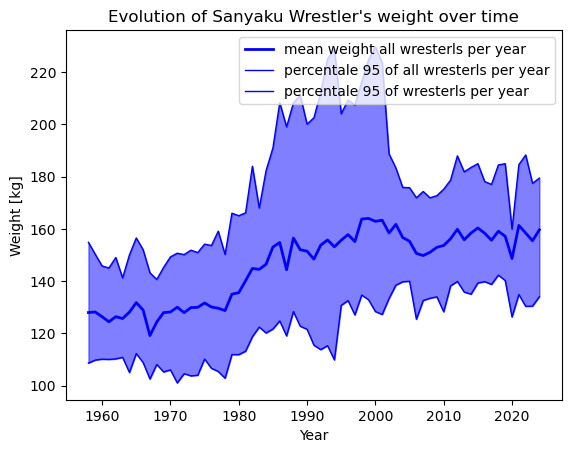

In [28]:
plt.fill_between(s['year'], y1=s['p5'], y2=s['p95'], color='blue', alpha=0.5)
plt.plot(s['year'], s['mean'], color='blue', linewidth=2, label='mean weight all wresterls per year')
plt.plot(s['year'], s['p5'], color='blue', linewidth=1, label='percentale 95 of all wresterls per year')
plt.plot(s['year'], s['p95'], color='blue', linewidth=1, label='percentale 95 of wresterls per year')
plt.title("Evolution of Sanyaku Wrestler's weight over time")
plt.xlabel('Year')
plt.ylabel('Weight [kg]')
plt.legend()
plt.show();

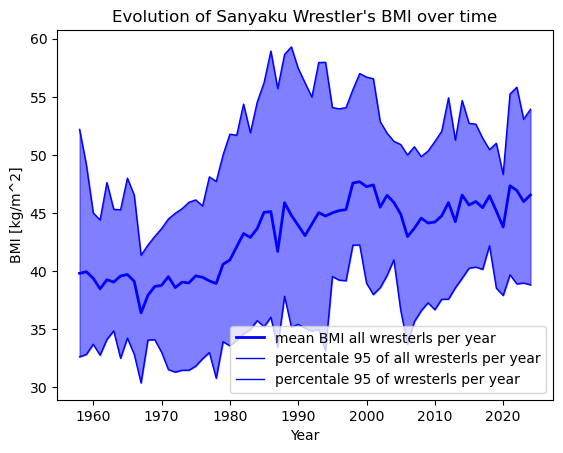

In [29]:
plt.fill_between(s['year'], y1=s['bmi_p5'], y2=s['bmi_p95'], color='blue', alpha=0.5)
plt.plot(s['year'], s['bmi_mean'], color='blue', linewidth=2, label='mean BMI all wresterls per year')
plt.plot(s['year'], s['bmi_p5'], color='blue', linewidth=1, label='percentale 95 of all wresterls per year')
plt.plot(s['year'], s['bmi_p95'], color='blue', linewidth=1, label='percentale 95 of wresterls per year')
plt.title("Evolution of Sanyaku Wrestler's BMI over time")
plt.xlabel('Year')
plt.ylabel('BMI [kg/m^2]')
plt.legend()
plt.show();

In [33]:
mask = w['rank'] == 'maegashira'

base = w.loc[mask, :].groupby(by=['rikishi_id', 'year']).agg(
    weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()

s = base.groupby(by='year').agg(
    mean=pd.NamedAgg(column='weight', aggfunc='mean'),
    std=pd.NamedAgg(column='weight', aggfunc='std'),
    median=pd.NamedAgg(column='weight', aggfunc='median'),
    p5=pd.NamedAgg(column='weight', aggfunc=p5),
    p95=pd.NamedAgg(column='weight', aggfunc=p95),
    bmi_mean=pd.NamedAgg(column='bmi', aggfunc='mean'),
    bmi_std=pd.NamedAgg(column='bmi', aggfunc='std'),
    bmi_median=pd.NamedAgg(column='bmi', aggfunc='median'),
    bmi_p5=pd.NamedAgg(column='bmi', aggfunc=p5),
    bmi_p95=pd.NamedAgg(column='bmi', aggfunc=p95),
).reset_index()

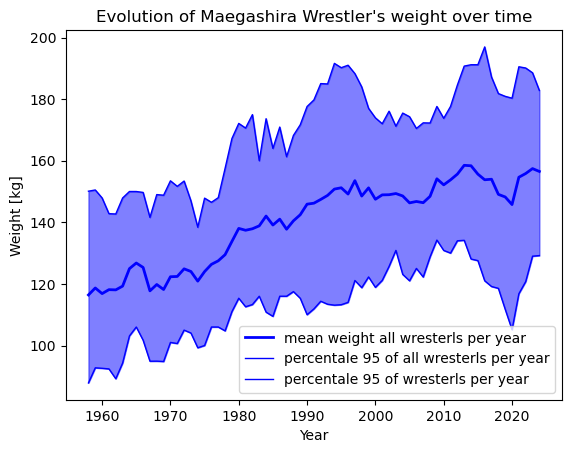

In [34]:
plt.fill_between(s['year'], y1=s['p5'], y2=s['p95'], color='blue', alpha=0.5)
plt.plot(s['year'], s['mean'], color='blue', linewidth=2, label='mean weight all wresterls per year')
plt.plot(s['year'], s['p5'], color='blue', linewidth=1, label='percentale 95 of all wresterls per year')
plt.plot(s['year'], s['p95'], color='blue', linewidth=1, label='percentale 95 of wresterls per year')
plt.title("Evolution of Maegashira Wrestler's weight over time")
plt.xlabel('Year')
plt.ylabel('Weight [kg]')
plt.legend()
plt.show();

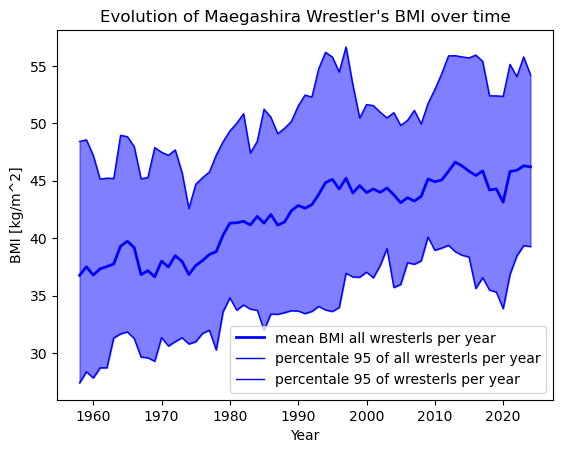

In [36]:
plt.fill_between(s['year'], y1=s['bmi_p5'], y2=s['bmi_p95'], color='blue', alpha=0.5)
plt.plot(s['year'], s['bmi_mean'], color='blue', linewidth=2, label='mean BMI all wresterls per year')
plt.plot(s['year'], s['bmi_p5'], color='blue', linewidth=1, label='percentale 95 of all wresterls per year')
plt.plot(s['year'], s['bmi_p95'], color='blue', linewidth=1, label='percentale 95 of wresterls per year')
plt.title("Evolution of Maegashira Wrestler's BMI over time")
plt.xlabel('Year')
plt.ylabel('BMI [kg/m^2]')
plt.legend()
plt.show();

Compare mean weight evolution for different ranks whithin sekitoris to see if the sanyaku level wrestlers behave differently than the rest. For the above, it looks like it. There is a peak at sanyaku level in the late 90s but maegashiras keep getting heavier

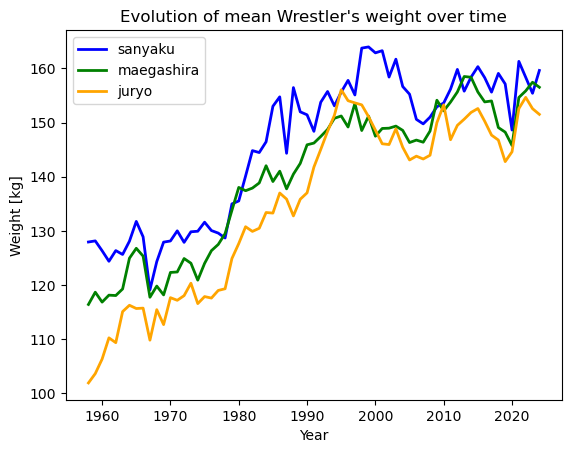

In [37]:
mask = w['sanyaku'] == True

base = w.loc[mask, :].groupby(by=['rikishi_id', 'year']).agg(
    weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()

s = base.groupby(by='year').agg(
    mean=pd.NamedAgg(column='weight', aggfunc='mean'),
).reset_index()
plt.plot(s['year'], s['mean'], color='blue', linewidth=2, label='sanyaku')


mask = w['rank'] == 'maegashira'

base = w.loc[mask, :].groupby(by=['rikishi_id', 'year']).agg(
    weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()

s = base.groupby(by='year').agg(
    mean=pd.NamedAgg(column='weight', aggfunc='mean'),
).reset_index()
plt.plot(s['year'], s['mean'], color='green', linewidth=2, label='maegashira')


mask = w['rank'] == 'juryo'

base = w.loc[mask, :].groupby(by=['rikishi_id', 'year']).agg(
    weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()

s = base.groupby(by='year').agg(
    mean=pd.NamedAgg(column='weight', aggfunc='mean'),
).reset_index()
plt.plot(s['year'], s['mean'], color='orange', linewidth=2, label='juryo')

plt.title("Evolution of mean Wrestler's weight over time")
plt.xlabel('Year')
plt.ylabel('Weight [kg]')
plt.legend()
plt.show();

Interestingly, weight goes up until the mid 90s and from there more or less stabilizes. But increased much more at the sanyaku level and then decreased. I guess this is what people say by "weight went down". It doesn't seem like it did, rather heavy sanyaku dissapeared and now all ranks are more or less similar, though sanyaku wrestlers are still heavier. Are they still taller as well or just heavier?

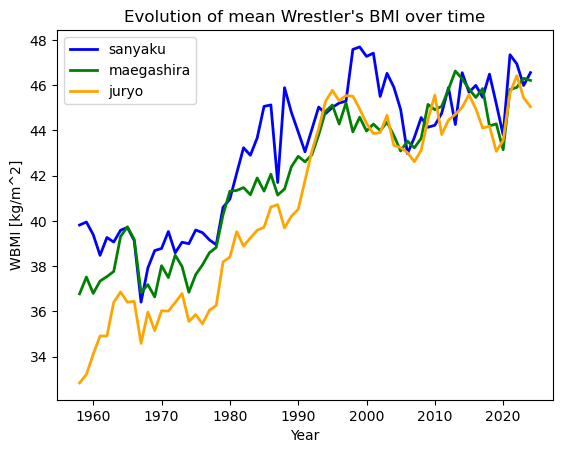

In [39]:
mask = w['sanyaku'] == True

base = w.loc[mask, :].groupby(by=['rikishi_id', 'year']).agg(
    weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()

s = base.groupby(by='year').agg(
    mean=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()
plt.plot(s['year'], s['mean'], color='blue', linewidth=2, label='sanyaku')


mask = w['rank'] == 'maegashira'

base = w.loc[mask, :].groupby(by=['rikishi_id', 'year']).agg(
    weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()


s = base.groupby(by='year').agg(
    mean=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()
plt.plot(s['year'], s['mean'], color='green', linewidth=2, label='maegashira')


mask = w['rank'] == 'juryo'

base = w.loc[mask, :].groupby(by=['rikishi_id', 'year']).agg(
    weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()

s = base.groupby(by='year').agg(
    mean=pd.NamedAgg(column='bmi', aggfunc='mean'),
).reset_index()
plt.plot(s['year'], s['mean'], color='orange', linewidth=2, label='juryo')

plt.title("Evolution of mean Wrestler's BMI over time")
plt.xlabel('Year')
plt.ylabel('WBMI [kg/m^2]')
plt.legend()
plt.show();

Interesting, so it seems that sanyaku wrestlers are heavier but because they are taller?

In [51]:
w['mixed_rank'] = w['rank']
mask = w['rank'].isin(sanyaku)
w.loc[mask, 'mixed_rank'] = 'sanyaku'

mask = (w['year'] >= 2005) & (w['mixed_rank'].isin(['sanyaku', 'maegashira', 'juryo']))
df = w.loc[mask, ['year', 'mixed_rank', 'weight', 'bmi']].reset_index(drop=True) #\
    # .reset_index() \
    # .groupby(by=['rikishi_id', 'year']) \
    # .agg(weight=pd.NamedAgg(column='weight', aggfunc='mean'),
    #      bmi=pd.NamedAgg(column='bmi', aggfunc='mean'),
    #     ) \
    

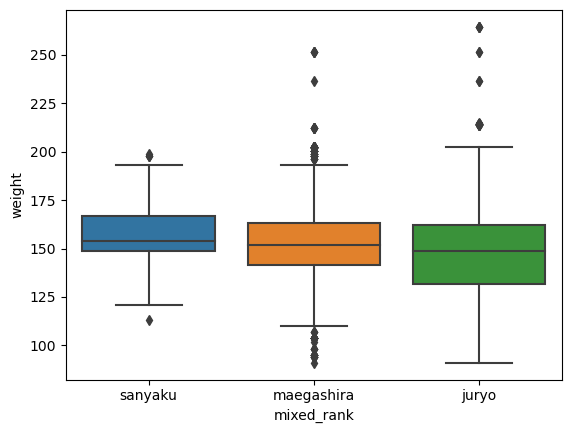

In [52]:
sns.boxplot(
    data=df,
    x='mixed_rank',
    y='weight'
);

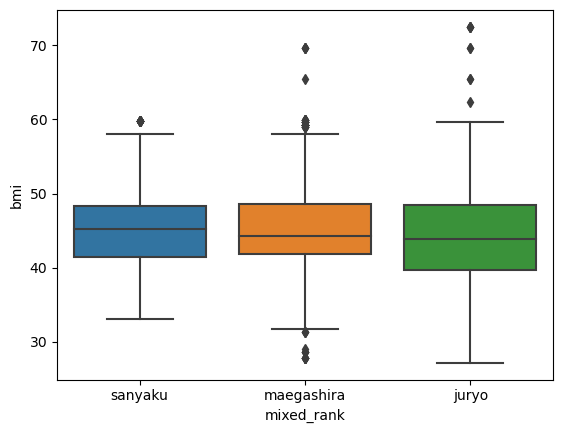

In [159]:
sns.boxplot(
    data=df,
    x='mixed_rank',
    y='bmi'
);

# Height Analysis

In [118]:
mask = (~weights['weight'].isna().values) & (~heights['height'].isna().values)

cols = [
    'year',
    'height',
    'rank',
    'sanyaku',
    'makuuchi',
    'sekitori',
]

h = heights.loc[mask, cols]

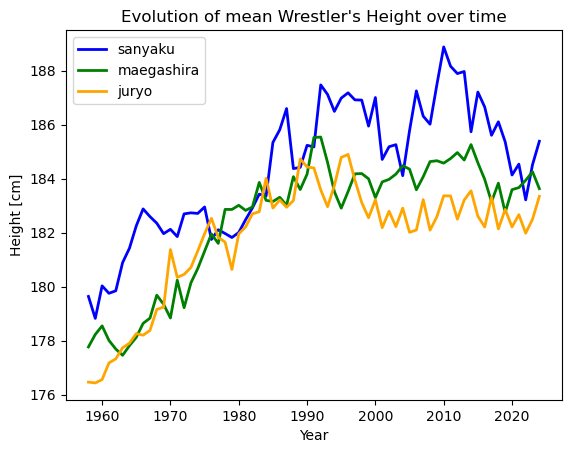

In [119]:
mask = h['sanyaku'] == True
s = h.loc[mask, ['year', 'height']].groupby(by='year').agg(
    mean=pd.NamedAgg(column='height', aggfunc='mean'),
).reset_index()
plt.plot(s['year'], s['mean'], color='blue', linewidth=2, label='sanyaku')


mask = h['rank'] == 'maegashira'
s = h.loc[mask, ['year', 'height']].groupby(by='year').agg(
    mean=pd.NamedAgg(column='height', aggfunc='mean'),
).reset_index()
plt.plot(s['year'], s['mean'], color='green', linewidth=2, label='maegashira')


mask = h['rank'] == 'juryo'
s = h.loc[mask, ['year', 'height']].groupby(by='year').agg(
    mean=pd.NamedAgg(column='height', aggfunc='mean'),
).reset_index()
plt.plot(s['year'], s['mean'], color='orange', linewidth=2, label='juryo')

plt.title("Evolution of mean Wrestler's Height over time")
plt.xlabel('Year')
plt.ylabel('Height [cm]')
plt.legend()
plt.show();

Yes, it seems that's the case. Sanyaku are taller on average than Maegashira, and this than juryo. This confirms the idea than height is more important than weight in modern sumo, though it could be related, as we saw that taller wrestlers are heavier but leaner?

In [160]:
h['mixed_rank'] = h['rank']
mask = h['rank'].isin(sanyaku)
h.loc[mask, 'mixed_rank'] = 'sanyaku'

mask = (h['year'] >= 2005) & (h['mixed_rank'].isin(['sanyaku', 'maegashira', 'juryo']))
df_height = h.loc[mask, ['mixed_rank', 'height']].reset_index(drop=True)

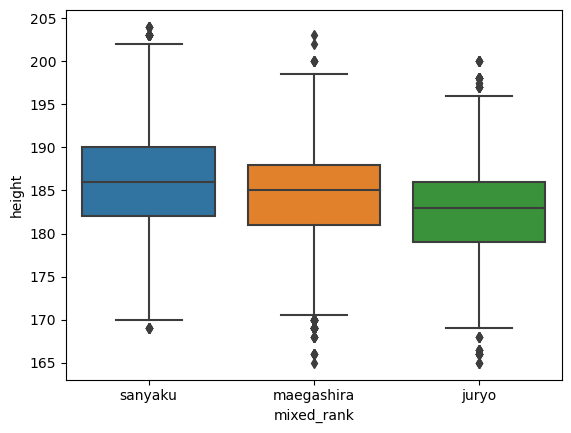

In [155]:
sns.boxplot(
    data=df_height,        
    x="mixed_rank",
    y="height",
);

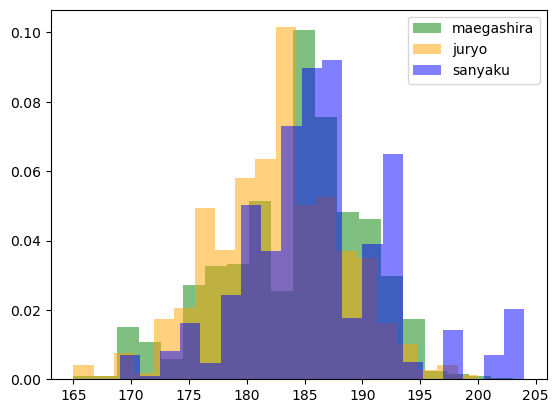

In [168]:
plt.hist(df_height[df_height['mixed_rank'] == 'maegashira']['height'], bins=20, color='green', alpha=0.5, label='maegashira', density=True)
plt.hist(df_height[df_height['mixed_rank'] == 'juryo']['height'], bins=20, color='orange', alpha=0.5, label='juryo', density=True)
plt.hist(df_height[df_height['mixed_rank'] == 'sanyaku']['height'], bins=20, color='blue', alpha=0.5, label='sanyaku', density=True)
plt.legend();

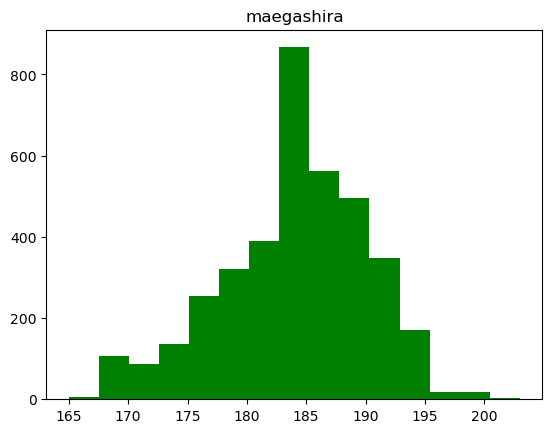

In [171]:
plt.hist(df_height[df_height['mixed_rank'] == 'maegashira']['height'], bins=15, color='green')
plt.title('maegashira');

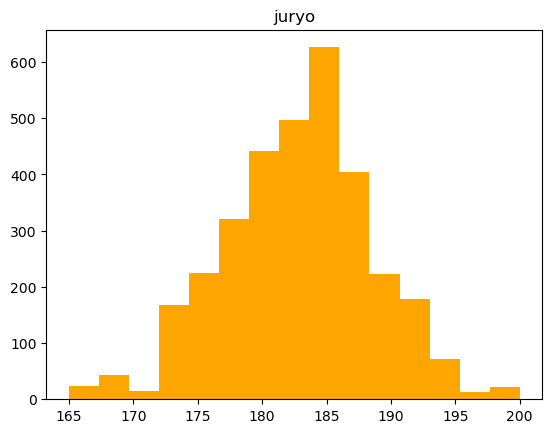

In [173]:
plt.hist(df_height[df_height['mixed_rank'] == 'juryo']['height'], bins=15, color='orange')
plt.title('juryo');

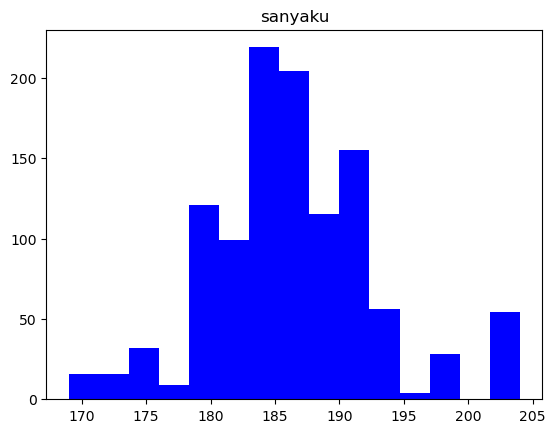

In [174]:
plt.hist(df_height[df_height['mixed_rank'] == 'sanyaku']['height'], bins=15, color='blue')
plt.title('sanyaku');

In [106]:
hb = h.groupby(by=['rikishi_id', 'year']).agg(
    mean=pd.NamedAgg(column='height', aggfunc='mean'),
).reset_index()

s = hb.groupby(by='year').agg(
    mean=pd.NamedAgg(column='height', aggfunc='mean'),
    std=pd.NamedAgg(column='height', aggfunc='std'),
    median=pd.NamedAgg(column='height', aggfunc='median'),
    p5=pd.NamedAgg(column='height', aggfunc=p5),
    p95=pd.NamedAgg(column='height', aggfunc=p95),
).reset_index()

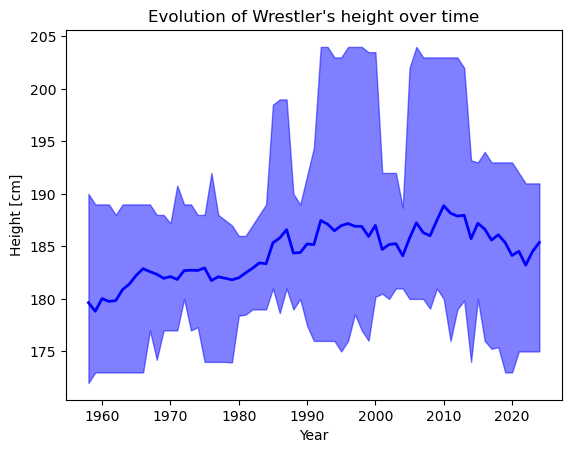

In [107]:
plt.plot(s['year'], s['mean'], color='blue', linewidth=2)
plt.fill_between(s['year'], y1=s['p5'], y2=s['p95'], color='blue', alpha=0.5)
plt.title("Evolution of Wrestler's height over time")
plt.xlabel('Year')
plt.ylabel('Height [cm]')
plt.show();

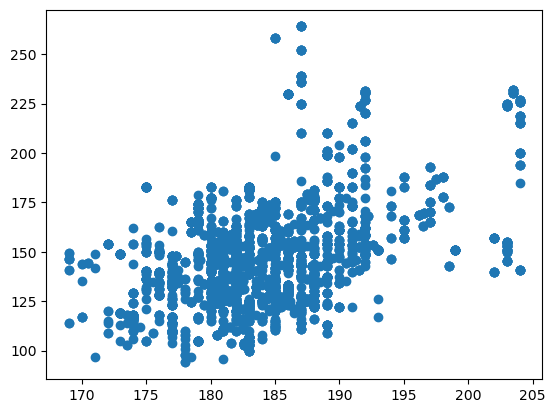

In [108]:
plt.scatter(hb['height'], base['weight'])

In [109]:
^

SyntaxError: invalid syntax (1184014603.py, line 1)